In [2]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp "/content/drive/My Drive/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Mounted at /content/drive


In [3]:
# Basic imports
import matplotlib.pyplot as plt
import zipfile

# Download and preprocess the dataset
!kaggle datasets download -d gpiosenka/70-dog-breedsimage-data-set
with zipfile.ZipFile('70-dog-breedsimage-data-set.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

 99% 213M/215M [00:09<00:00, 24.6MB/s]
100% 215M/215M [00:09<00:00, 22.8MB/s]


In [5]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load and preprocess the data
data = pd.read_csv('dogs.csv')
data['filepath'] = data['filepaths']

# Use only a small subset of images to save memory
subset_data = data.sample(500, random_state=42)

images = []
for filepath in subset_data['filepath']:
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    images.append(img)
images = np.array(images)

# Define the VAE architecture
input_shape = (64, 64, 1)
latent_dim = 10

inputs = Input(shape=input_shape)
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

latent_inputs = Input(shape=(latent_dim,))
x = Dense(16 * 16 * 64, activation='relu')(latent_inputs)
x = Reshape((16, 16, 64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
outputs = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

def vae_loss(x, x_decoded_mean):
    xent_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(x), tf.keras.backend.flatten(x_decoded_mean))
    kl_loss = - 0.5 * tf.keras.backend.mean(1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae.add_loss(vae_loss(inputs, outputs))
vae.compile(optimizer=Adam(learning_rate=0.001))

# Prepare the data for training
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Train the VAE
history = vae.fit(X_train, None, epochs=100, batch_size=32, validation_data=(X_test, None))

# Save the model
encoder.save('encoder.h5')
decoder.save('decoder.h5')


Epoch 1/100
13/13 [==============================] - 9s 391ms/step - loss: 0.6955 - val_loss: 0.6923
Epoch 2/100
13/13 [==============================] - 5s 370ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 3/100
13/13 [==============================] - 7s 510ms/step - loss: 0.6924 - val_loss: 0.6926
Epoch 4/100
13/13 [==============================] - 5s 375ms/step - loss: 0.6925 - val_loss: 0.6922
Epoch 5/100
13/13 [==============================] - 6s 513ms/step - loss: 0.6922 - val_loss: 0.6921
Epoch 6/100
13/13 [==============================] - 5s 364ms/step - loss: 0.6922 - val_loss: 0.6924
Epoch 7/100
13/13 [==============================] - 5s 371ms/step - loss: 0.6921 - val_loss: 0.6922
Epoch 8/100
13/13 [==============================] - 7s 568ms/step - loss: 0.6920 - val_loss: 0.6921
Epoch 9/100
13/13 [==============================] - 5s 349ms/step - loss: 0.6919 - val_loss: 0.6925
Epoch 10/100
13/13 [==============================] - 5s 352ms/step - loss: 0.6920 - val_lo

1/1 [==============================] - 1s 632ms/step


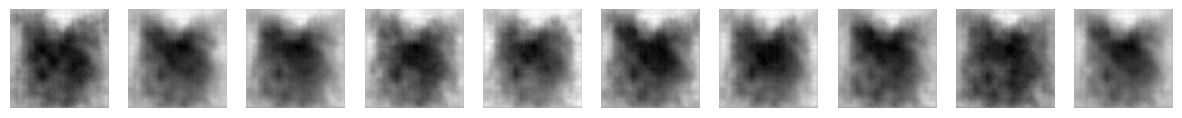

In [11]:
import matplotlib.pyplot as plt

def plot_generated_images(decoder, n=10):
    # Generate random latent vectors
    latent_vectors = np.random.normal(size=(n, latent_dim))

    # Decode the latent vectors into images
    generated_images = decoder.predict(latent_vectors)

    # Plot the generated images
    fig, axes = plt.subplots(1, n, figsize=(n * 1.5, 1.5))
    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i].squeeze(), cmap='gray')
        ax.axis('off')

    plt.show()

# Plot some generated images
plot_generated_images(decoder)
